In [1]:
import os
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from PIL import Image
from torch.optim import Adam

from splat.custom_pytorch_implementation.create_image_auto import (
    Camera,
    create_image_full_auto_multiple_gaussians_with_splat_gaussians,
)
from splat.custom_pytorch_implementation.create_image_custom import (
    create_image_full_custom_multiple_gaussians_with_splat_gaussians,
)
from splat.gaussians import Gaussians
from splat.render_engine.gaussianScene2 import GaussianScene2


def return_gaussians() -> Gaussians:
    """
    Creates a set of Gaussian parameters as nn.Parameters. 
    These parameters are used to build a Gaussian scene and will be optimized.
    
    Note: Call this function only once before training so that the optimizer 
    holds persistent parameter references. Each forward pass will create a 
    fresh computation graph.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    points = torch.tensor([[0.101, 0.1001, 4.0], [0.0999, 0.0999, 4.1]], dtype=torch.float32, device=device)
    colors = torch.tensor([[0.4, 0.6, 0.8], [0.1, 0.15, 0.2]], dtype=torch.float32, device=device)
    scales = torch.tensor([[0.1, 0.15, 0.2], [0.2, 0.16, 0.1]], dtype=torch.float32, device=device)
    quaternions = torch.tensor([[0.5, 0.02, 0.03, 0.001], [0.2, 0.04, 0.03, 0.001]], dtype=torch.float32, device=device)
    opacity = torch.tensor([0.5, 0.9], dtype=torch.float32, device=device)
    
    gaussians = Gaussians(
        points=points,
        colors=colors,
        scales=scales,
        quaternions=quaternions,
        opacity=opacity,
        requires_grad=True
    )
    
    return gaussians


def return_camera() -> Camera:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    focal_x = torch.tensor([100.0], device=device, dtype=torch.float32)
    focal_y = torch.tensor([100.0], device=device, dtype=torch.float32)
    width = 32
    height = 32
    camera_rotation = torch.tensor([1, 0, 0, 0], device=device, dtype=torch.float32).unsqueeze(0)
    camera_translation = torch.tensor([[-0.1, -0.1, 0.0]], device=device, dtype=torch.float32)

    return Camera(
        focal_x=focal_x,
        focal_y=focal_y,
        c_x=0.0,
        c_y=0.0,
        width=width,
        height=height,
        camera_rotation=camera_rotation,
        camera_translation=camera_translation,
        device=device
    )


def return_gt_image() -> torch.Tensor:
    gt_image = Image.open("../custom_pytorch_implementation/gt.png")
    gt_image = np.array(gt_image) / 255.0
    gt_image = torch.tensor(gt_image).float()
    return gt_image.to("cuda")


def preprocess_for_gaussian_scene(camera: Camera, gaussian_scene: GaussianScene2) -> Gaussians:
    extrinsic_matrix = camera.extrinsic_matrix
    intrinsic_matrix = camera.intrinsic_matrix
    focal_x = camera.focal_x
    focal_y = camera.focal_y
    width = camera.width
    height = camera.height
    tile_size = 16
    preprocessed_gaussians = gaussian_scene.preprocess(
        extrinsic_matrix=extrinsic_matrix,
        intrinsic_matrix=intrinsic_matrix,
        focal_x=focal_x,
        focal_y=focal_y,
        width=width,
        height=height,
        tile_size=tile_size,
    )
    return preprocessed_gaussians

/home/da2986/intro_to_gaussian_splatting/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Auto

In [ ]:
camera = return_camera()
gaussians = return_gaussians()
gt_image = return_gt_image()

optimizer = Adam([
    gaussians.points,
    gaussians.colors,
    gaussians.scales,
    gaussians.quaternions,
    gaussians.opacity,
], lr=0.001)
loss = torch.nn.MSELoss()
pbar = tqdm.tqdm(range(50))
for i in pbar:
    output_auto1 = create_image_full_auto_multiple_gaussians_with_splat_gaussians(
        camera, gaussians, camera.height, camera.width, verbose=False
    )
    loss_value = loss(output_auto1, gt_image.float())
    print(f"I: {i}. Loss value", loss_value.item())
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)

plt.imshow(output_auto1.detach().cpu().numpy())
plt.show()



  0%|          | 0/50 [00:00<?, ?it/s]/home/da2986/intro_to_gaussian_splatting/splat/custom_pytorch_implementation/auto_functions.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return final_color, torch.tensor(current_T)


I: 0. Loss value 0.01618906483054161


  2%|▏         | 1/50 [00:02<01:43,  2.11s/it]

I: 1. Loss value 0.01998605579137802


  4%|▍         | 2/50 [00:03<01:20,  1.67s/it]

I: 2. Loss value 0.01844169944524765


  6%|▌         | 3/50 [00:04<01:12,  1.54s/it]

I: 3. Loss value 0.015570840798318386


  8%|▊         | 4/50 [00:06<01:08,  1.49s/it]

I: 4. Loss value 0.014558754861354828


 10%|█         | 5/50 [00:07<01:06,  1.48s/it]

I: 5. Loss value 0.007656083907932043


 12%|█▏        | 6/50 [00:09<01:05,  1.49s/it]

I: 6. Loss value 0.010975882411003113


 14%|█▍        | 7/50 [00:10<01:04,  1.49s/it]

I: 7. Loss value 0.01234724372625351


 16%|█▌        | 8/50 [00:12<01:00,  1.45s/it]

I: 8. Loss value 0.009772347286343575


 18%|█▊        | 9/50 [00:13<00:58,  1.42s/it]

I: 9. Loss value 0.00865640863776207


 20%|██        | 10/50 [00:14<00:55,  1.40s/it]

I: 10. Loss value 0.01089880894869566


 22%|██▏       | 11/50 [00:16<00:53,  1.38s/it]

I: 11. Loss value 0.010082813911139965


# Custom

 10%|█         | 1/10 [00:02<00:21,  2.44s/it]

I: 0. Loss value 0.01618906483054161


 20%|██        | 2/10 [00:04<00:19,  2.43s/it]

I: 1. Loss value 0.01998605579137802


 30%|███       | 3/10 [00:07<00:16,  2.42s/it]

I: 2. Loss value 0.01844169944524765


 40%|████      | 4/10 [00:09<00:14,  2.42s/it]

I: 3. Loss value 0.015570840798318386


 50%|█████     | 5/10 [00:12<00:12,  2.46s/it]

I: 4. Loss value 0.014558754861354828


 60%|██████    | 6/10 [00:14<00:09,  2.45s/it]

I: 5. Loss value 0.007656083907932043


 70%|███████   | 7/10 [00:17<00:07,  2.44s/it]

I: 6. Loss value 0.010975882411003113


 80%|████████  | 8/10 [00:19<00:04,  2.44s/it]

I: 7. Loss value 0.01234724372625351


 90%|█████████ | 9/10 [00:22<00:02,  2.47s/it]

I: 8. Loss value 0.009772347286343575


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]

I: 9. Loss value 0.008656409569084644


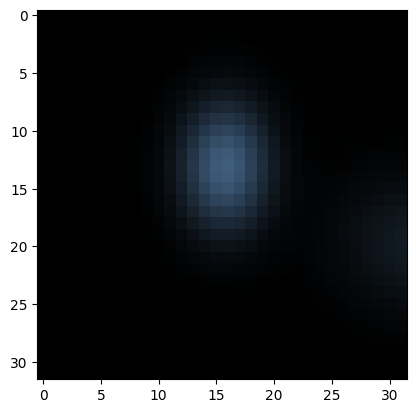

In [4]:
camera = return_camera()
gaussians = return_gaussians()
gaussians.points.retain_grad()
gt_image = return_gt_image()

optimizer = Adam([
    gaussians.points,
    gaussians.colors,
    gaussians.scales,
    gaussians.quaternions,
    gaussians.opacity,
], lr=0.001)
loss = torch.nn.MSELoss()
pbar = tqdm.tqdm(range(50))

for i in pbar:
    output_custom1 = create_image_full_custom_multiple_gaussians_with_splat_gaussians(
        camera, gaussians, camera.height, camera.width, verbose=False
    )
    loss_value = loss(output_custom1, gt_image.float())
    loss_value.backward()
    print(f"I: {i}. Loss value", loss_value.item())
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)

plt.imshow(output_custom1.detach().cpu().numpy())
plt.show()

# In CUDA

  0%|          | 0/10 [00:00<?, ?it/s]

I: 0. Loss value 0.01618906483054161
I: 1. Loss value 0.01998605765402317
I: 2. Loss value 0.01844169571995735
I: 3. Loss value 0.015570825897157192


100%|██████████| 10/10 [00:00<00:00, 72.96it/s]


I: 4. Loss value 0.014558646827936172
I: 5. Loss value 0.0076560769230127335
I: 6. Loss value 0.010975736193358898
I: 7. Loss value 0.012347094714641571
I: 8. Loss value 0.009772296994924545
I: 9. Loss value 0.008656474761664867


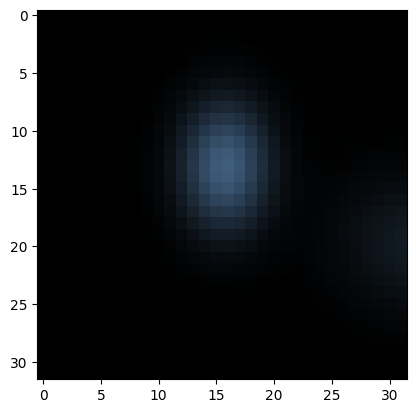

In [5]:
gaussians = return_gaussians()


optimizer = Adam([
    gaussians.points,
    gaussians.colors,
    gaussians.scales,
    gaussians.quaternions,
    gaussians.opacity,
], lr=0.001)


pbar = tqdm.tqdm(range(50))
for i in pbar:
    gaussian_scene = GaussianScene2(gaussians=gaussians)
    preprocessed_gaussians = preprocess_for_gaussian_scene(camera, gaussian_scene)

    output_scene = gaussian_scene.render_cuda(
        preprocessed_gaussians=preprocessed_gaussians.clone(),
        height=camera.height,
        width=camera.width,
        tile_size=16,
    )
    final_output = torch.zeros_like(output_scene)
    final_output = output_scene

    loss_value = loss(final_output, gt_image.float())
    print(f"I: {i}. Loss value", loss_value.item())
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)

plt.imshow(final_output.detach().cpu().numpy())
plt.show()

In [9]:
preprocessed_gaussians.means_3d.grad

tensor([[-1.4761e-05,  1.2789e-05,  0.0000e+00],
        [-2.8760e-07, -2.5588e-08,  0.0000e+00]], device='cuda:0')

In [5]:
torch.allclose(output_auto1, output_scene)

False

In [5]:
# Find pixel location with maximum difference between images
diff = torch.abs(output_scene - output_auto1)
max_diff = torch.max(diff.sum(dim=-1))  # Sum across color channels
max_diff_idx = torch.argmax(diff.sum(dim=-1))  # Get flattened index

# Convert flat index to 2D coordinates
h = max_diff_idx // camera.width
w = max_diff_idx % camera.width

print(f"Maximum difference occurs at pixel ({h}, {w})")
print(f"Scene value: {output_scene[h,w]}")
print(f"Auto value: {output_auto1[h,w]}")


Maximum difference occurs at pixel (12, 2)
Scene value: tensor([0.1792, 0.2688, 0.3583], device='cuda:0')
Auto value: tensor([0.1792, 0.2688, 0.3583], device='cuda:0', grad_fn=<SelectBackward0>)


/var/tmp/ipykernel_4027/1678247111.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  h = max_diff_idx // camera.width
